# Analysis of the Barcelona property market

The script visualizes the property market in Barcelona and identifies the good investment. The data is stored in './data/data.csv' and was obtained using the script 'Idealista API'.

*Author: Mislav Jordanić*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

df_original = pd.read_csv('./data/data.csv')
df=df_original.copy()

## Organize data

In [2]:
# Remove unnecesarry columns
df = df[['propertyCode', 'floor', 'price', 'propertyType', 'size',
       'exterior', 'rooms', 'bathrooms', 'district', 'neighborhood', 'latitude',
       'longitude', 'priceByArea', 'status', 'hasLift', 'Week']]

df['propertyCode'] = pd.to_numeric(df['propertyCode'], errors='coerce') 
df['propertyType'] = df['propertyType'].astype('category')
df['district'] = df['district'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')
df['status'] = df['status'].astype('category')
df['floor'] = df['floor'].astype('str')
# drop identical rows (keep only the first instance)
df.drop_duplicates(inplace=True)

df.reset_index(drop=True, inplace=True)
df.head(5)


propertyCode floor     price propertyType  size  exterior  rooms  \
0      87688139     3  172000.0         flat  67.0     False      2   
1      89127122     2  130000.0         flat  32.0      True      1   
2      89115559     1  149000.0         flat  45.0     False      2   
3      89102591     5  220000.0         flat  54.0      True      2   
4      89123676    bj  103000.0         flat  67.0     False      2   

   bathrooms      district                       neighborhood   latitude  \
0          2      Eixample    L'Antiga Esquerra de l'Eixample  41.387739   
1          1  Ciutat Vella                           El Raval  41.380189   
2          1    Nou Barris                              Porta  41.430582   
3          1      Eixample                 La Sagrada Família  41.410451   
4          1    Nou Barris  Can Peguera - El Turó de la Peira  41.432788   

   longitude  priceByArea status hasLift  Week  
0   2.151873       2567.0    NaN     NaN    14  
1   2.165333       4063.0   good   False    14  
2   2.177449       3311.0   good    True    14  
3   2.178700       4074.0   good    True    14  
4   2.169198       1537.0  renew    True    14

## Analyze Duplicates

In [3]:
dup = df.copy()
dup = dup.join(df_original['externalReference'])
dup['duplicates'] = dup.duplicated(subset='propertyCode', keep=False)
dup['duplicates2'] = dup.duplicated(subset='externalReference', keep=False)

dup.duplicates.sum()
dup.loc[dup['duplicates2']==True].sort_values(by='externalReference').head(50)


propertyCode floor     price propertyType   size  exterior  rooms  \
621       89152942     2  298000.0         flat   85.0      True      3   
619       89147692     2  188000.0         flat   91.0      True      2   
730       89137501     4  224999.0         flat   68.0      True      2   
1978      89237186     1  255000.0         flat   70.0      True      2   
742       89140262     4  385000.0         flat   80.0     False      3   
4468      89437424     1  227000.0         flat   81.0      True      3   
1979      89250464     6  219000.0         flat   53.0     False      2   
606       89150349     1  279000.0         flat   80.0      True      4   
4243      89428500     6  129500.0    penthouse   55.0      True      3   
4257      89415690     2  159000.0         flat   62.0     False      3   
3118      89383473     8  250000.0         flat   80.0      True      4   
4211      89438822     1  285000.0         flat   80.0      True      3   
3125      89393622    bj  369000.0         flat  175.0      True      4   
4344      89408958     1  380000.0         flat   70.0      True      2   
4346      89409965    en  348000.0         flat   90.0      True      4   
4203      89403387     1  285000.0         flat   80.0      True      3   
3113      89378089     4  240000.0    penthouse   62.0      True      1   
4196      89430843     1  295000.0         flat  103.0      True      3   
4192      89432475     4  295000.0         flat   62.0      True      2   
3121      89365869     2  155000.0         flat   54.0      True      2   
1382      89232286     1  290000.0         flat  104.0      True      4   
1945      89248813     4  380000.0         flat   86.0      True      3   
3202      89366263     2  160000.0         flat   75.0     False      3   
4404      89423001    en  159000.0         flat   81.0      True      3   
4210      89436270    bj  199000.0         flat   80.0     False      1   
3119      89391325    en  245000.0         flat   56.0      True      2   
3124      89393448     3  320000.0         flat   77.0      True      3   
4417      89411960     2   81500.0         flat   56.0      True      2   
3205      89365915    en  297000.0         flat  108.0      True      3   
4389      89433712     1  116000.0         flat   61.0     False      2   
4418      87666696     5  395000.0    penthouse   51.0      True      1   
4387      89404930     5  320000.0         flat   80.0      True      4   
3114      89378079    bj  210000.0         flat   75.0      True      2   
4415      87666698     1  299000.0         flat   51.0      True      1   
4386      89021695     1  214990.0         flat   94.0     False      3   
3115      89374298     2  269000.0         flat   81.0      True      4   
3095      89386490     3  250000.0         flat   43.0     False      2   
4405      89393613    bj  310000.0         flat  185.0      True      3   
2896      87770137     3  215000.0         flat   63.0      True      2   
2897      89009425   nan  375000.0         flat   80.0      True      2   
4413      87666676     2  289000.0         flat   51.0      True      1   
3093      89378274    bj  199000.0         flat   80.0     False      1   
4384      89435425     8  315000.0         flat   85.0      True      3   
3094      88745288     1  270000.0         flat   81.0      True      3   
4393      89438459     8  315000.0         flat   85.0      True      3   
3097      88950689     3  340000.0         flat   80.0      True      1   
4408      85449943     4  125000.0         flat   62.0      True      3   
3090      89392464     3  270000.0         flat   75.0      True      3   
4385      89441749     2  209000.0         flat   70.0      True      3   
4414      89426879    bj  340000.0         flat   84.0      True      3   

      bathrooms                 district  \
621           1                Les Corts   
619           1               La Torrasa   
730           1               Sant Martí   
1978

In [4]:
# Create new column and mark all duplicates
dup = df.copy()
dup['duplicates'] = dup.duplicated(subset='propertyCode', keep=False)

dup = dup.loc[dup['duplicates'] == True]



# Assumption! If there are items with duplicated 'propertyCode', difference can only be
# in 'price' and 'Week'. Items with identical rows were already eliminated in previous cell.
cols = dup.columns.values
assert (dup.loc[:, cols[(cols != 'Week') | (cols != 'price')]
                 ].duplicated(keep=False)).sum()==0, 'Difference in columns other than "price" and "Week"!'

dup = dup.loc[:,['propertyCode', 'price', 'Week']].sort_values(by=['propertyCode', 'Week'])
dup['firstInstance'] = ~dup.duplicated(subset='propertyCode', keep='first')
aux = dup[['price', 'Week']].diff()
aux.columns = ['diffPrice', 'diffWeek']
dup = dup.join(aux)

dup['diffPrice'] = dup['diffPrice'].where(~dup['firstInstance'])
dup['diffWeek'] = dup['diffWeek'].where(~dup['firstInstance'])

# TODO: Check if it could be a useful feature in regression
#df=df.join(dup[['firstInstance', 'diffPrice']])

dup.sort_values(by='diffPrice').head(20)


propertyCode     price  Week  firstInstance  diffPrice  diffWeek
1643      89241136  210000.0    18          False   -29000.0       1.0
2189      89269779  299000.0    19          False   -26000.0       1.0
1642      89128932  243000.0    18          False   -21000.0       3.0
3663      89395648  299000.0    21          False   -20900.0       1.0
1654      89231724  361000.0    18          False   -15500.0       1.0
1647      89241240  210000.0    18          False   -15000.0       1.0
2106      85598010  153900.0    18          False   -14100.0       1.0
3700      89392393  365000.0    21          False   -12000.0       1.0
373       89125515  140000.0    15          False   -10000.0       1.0
3664      89394059  139000.0    21          False   -10000.0       1.0
3692      89263742  220000.0    21          False   -10000.0       1.0
2086      27341403  340000.0    18          False   -10000.0       1.0
2201      89267903  205000.0    19          False   -10000.0       1.0
1649      89232108  149900.0    18          False   -10000.0       1.0
2207      89269038  160000.0    19          False    -5000.0       1.0
3711      89394827  225000.0    21          False    -3000.0       1.0
2215      89267371  340000.0    19          False        0.0       1.0
2330      89267447  159000.0    19          False        0.0       1.0
2104      89247525  298000.0    18          False        0.0       1.0
1884      89246496  399000.0    18          False        0.0       1.0

There are 337 renewes adds without change in price (95.20%)


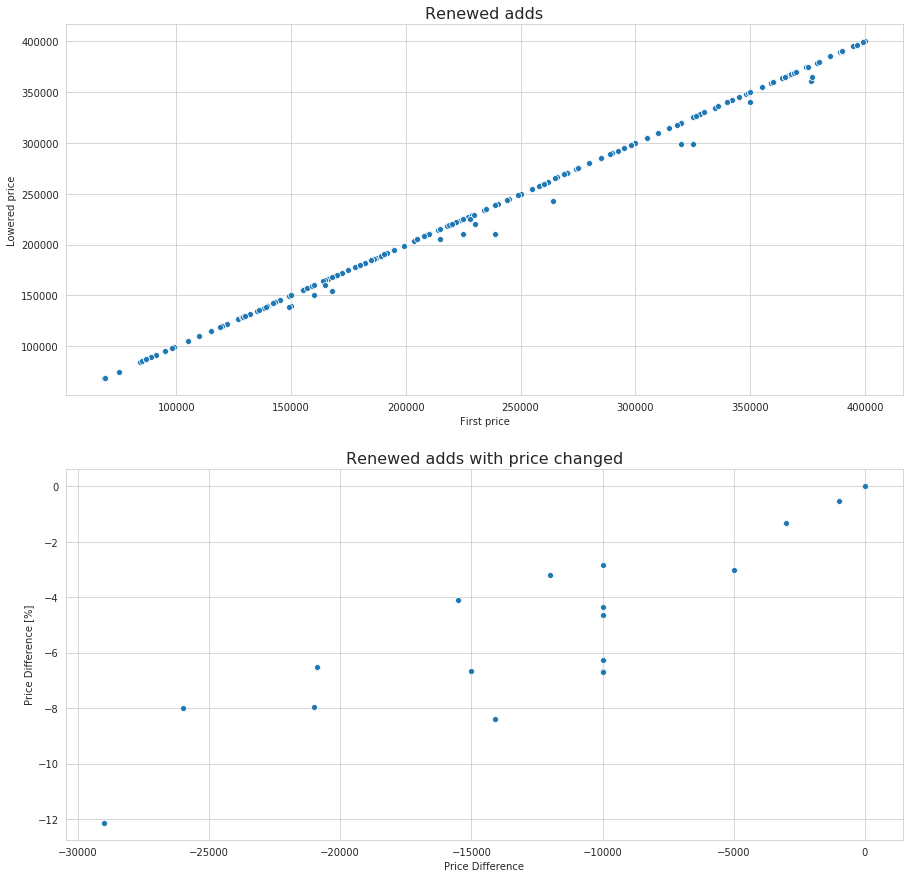

In [5]:
group_dup = dup.groupby('propertyCode')['price', 'Week'].agg([min, max])

group_dup['priceDifference'] = (
    group_dup[('price', 'min')] - group_dup[('price', 'max')])
group_dup['priceDifference%'] = 100 * (group_dup[(
    'price', 'min')] - group_dup[('price', 'max')]) / group_dup[('price', 'max')]


fig_size = (15, 15)
fig, ax = plt.subplots(2, figsize=fig_size)
dup.propertyCode = dup.propertyCode.astype(str)
sns.scatterplot(y=('price', 'min'), x=('price', 'max'), data=group_dup, ax=ax[0])
ax[0].set_title('Renewed adds', fontsize=16)
ax[0].set_xlabel('First price')
ax[0].set_ylabel('Lowered price')

sns.scatterplot(x='priceDifference', y='priceDifference%', data=group_dup, ax=ax[1])
ax[1].set_title('Renewed adds with price changed', fontsize=16)
ax[1].set_xlabel('Price Difference')
ax[1].set_ylabel('Price Difference [%]')

changed_price = ((group_dup[('price', 'min')] -
                  group_dup[('price', 'max')]) == 0).sum()
percent_changed_price = 100 * changed_price / group_dup.shape[0]
print('There are {} renewes adds without change in price ({:.2f}%)'.format(
    changed_price, percent_changed_price))

In [6]:
df.describe()

propertyCode          price           size        rooms    bathrooms  \
count  4.527000e+03    4527.000000    4527.000000  4527.000000  4527.000000   
mean   8.891706e+07  237230.465651      98.820543     2.600177     1.209410   
std    3.478155e+06   88232.798011    1708.253675     0.918018     0.421337   
min    7.938120e+05   12900.000000      11.000000     0.000000     0.000000   
25%    8.914620e+07  166000.000000      60.000000     2.000000     1.000000   
50%    8.925243e+07  225000.000000      72.000000     3.000000     1.000000   
75%    8.935838e+07  310000.000000      85.000000     3.000000     1.000000   
max    8.949457e+07  400000.000000  115000.000000     6.000000     3.000000   

          latitude    longitude   priceByArea         Week  
count  4527.000000  4527.000000   4527.000000  4527.000000  
mean     41.394622     2.159702   3295.745969    18.211398  
std       0.023752     0.031212   1113.489472     2.293851  
min      41.348364     2.083150      1.000000    14.000000  
25%      41.373659     2.135736   2500.000000    16.000000  
50%      41.389745     2.166147   3214.000000    19.000000  
75%      41.415124     2.182051   3933.000000    20.000000  
max      41.449543     2.227291  20818.000000    21.000000

In [7]:
# Remove propertise with surface area bigger than 150m2 or price higher than 6000 euros/m2
df=df.loc[df['size'] < 150]
df = df[df['priceByArea'] < 6000]
df.reset_index(drop=True, inplace=True)

In [8]:
# Show basic info of each column and number of NaNs

print('Info')
print(df.info())

print('\n\nNull Elements')
print(df.isnull().sum())

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4414 entries, 0 to 4413
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   propertyCode  4414 non-null   int64   
 1   floor         4414 non-null   object  
 2   price         4414 non-null   float64 
 3   propertyType  4414 non-null   category
 4   size          4414 non-null   float64 
 5   exterior      4414 non-null   bool    
 6   rooms         4414 non-null   int64   
 7   bathrooms     4414 non-null   int64   
 8   district      4322 non-null   category
 9   neighborhood  4316 non-null   category
 10  latitude      4414 non-null   float64 
 11  longitude     4414 non-null   float64 
 12  priceByArea   4414 non-null   float64 
 13  status        4047 non-null   category
 14  hasLift       4259 non-null   object  
 15  Week          4414 non-null   int64   
dtypes: bool(1), category(4), float64(5), int64(4), object(2)
memory usage: 405.2+ KB
None


Nul

## Impute missing district and neighborhood
Impute missing district and neighborhood based on kNN and geolocation (latitude, longitude)

In [9]:
print('\n\n There are '+ repr(df.district.isnull().sum()) +' Null Elements in district to be imputed.')

index_missing = df.index[df.district.isnull()]

X = df.dropna(subset=['district']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['district']).loc[:,'district']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## Evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'district'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 92 Null Elements in district to be imputed.


In [10]:
print('\n\n There are '+ repr(df.neighborhood.isnull().sum()) +' Null Elements in neighborhood to be imputed.')

index_missing = df.index[df.neighborhood.isnull()]

X = df.dropna(subset=['neighborhood']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['neighborhood']).loc[:,'neighborhood']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'neighborhood'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 98 Null Elements in neighborhood to be imputed.


## Analyze property types

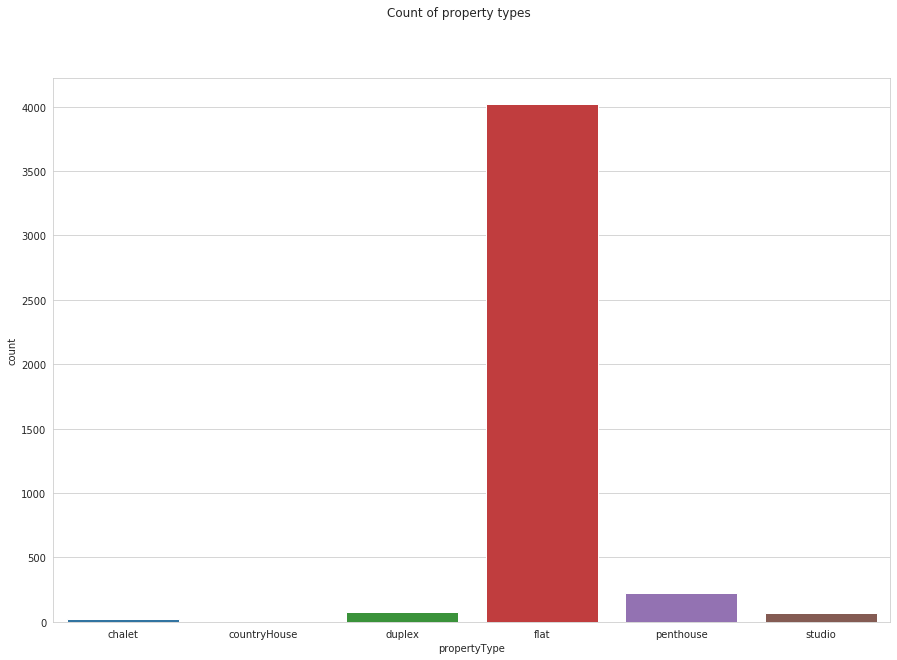

In [11]:
fig_size = (15,10)
fig, ax = plt.subplots(1,figsize=fig_size)
sns.countplot(x="propertyType", data=df, ax=ax);
fig.suptitle('Count of property types');

### Check distribution of Price, Size, and Price by Area

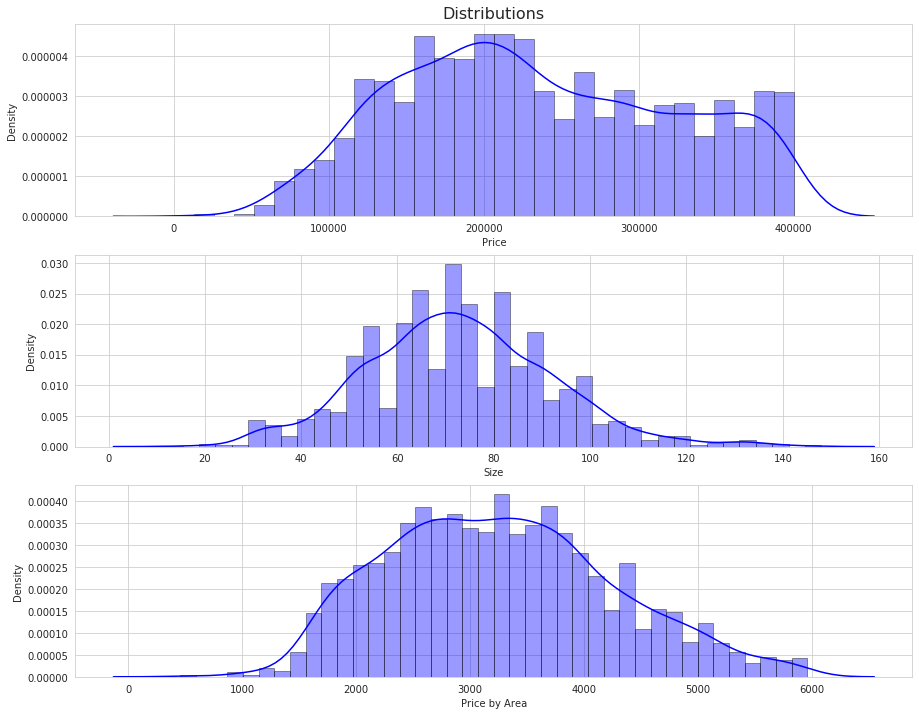

In [12]:
# Prices over 400k are exluded when requesting info from Idealista
fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

sns.distplot(df['price'], hist=True, kde=True, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[0])
ax[0].set_title('Distributions', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');


sns.distplot(df['size'], hist=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[1])
ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');


sns.distplot(df['priceByArea'], hist=True, kde=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[2])
ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');


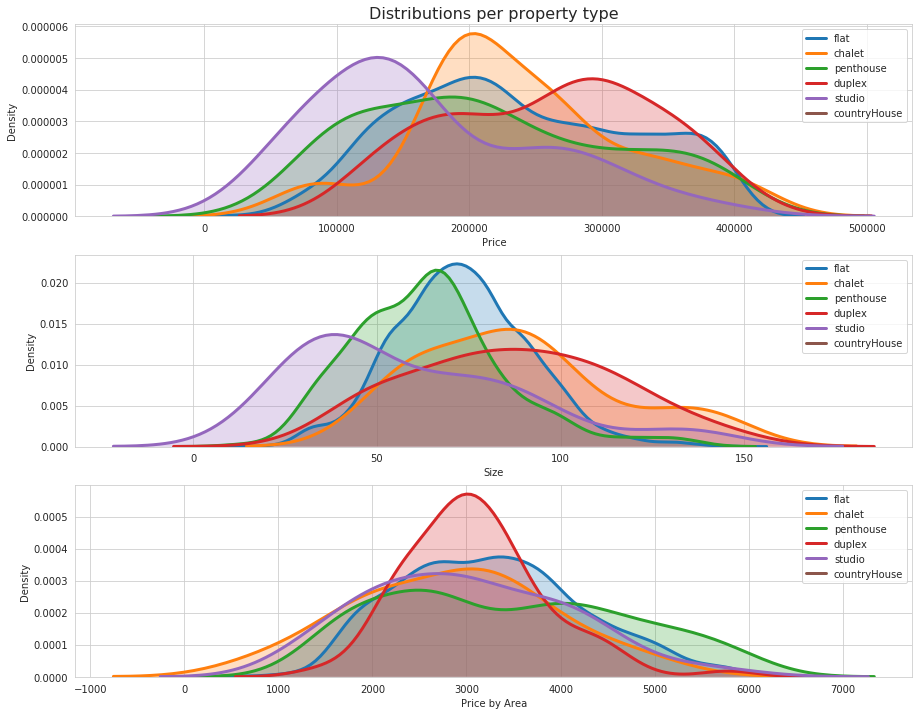

In [13]:
# Check for each type of property

fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

for typeOfProperty in df.propertyType.unique():
    dfDist = df.loc[df['propertyType']==typeOfProperty, ['price', 'size', 'priceByArea']]
    
    sns.distplot(dfDist['price'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[0])
    
    sns.distplot(dfDist['size'], hist=False, kde=True,
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[1])
    
    sns.distplot(dfDist['priceByArea'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[2])
    
# Add labels
ax[0].set_title('Distributions per property type', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');

ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');

ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');
    
    

### Scatter plot of Price by Area vs. Size for each property type

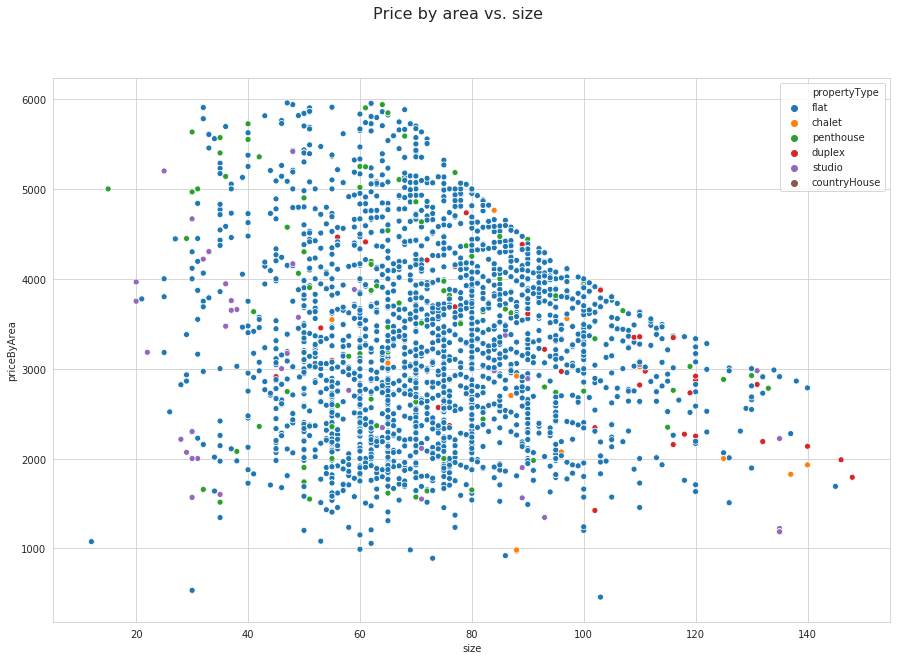

In [14]:
fig_size = (15,10)
fig, ax = plt.subplots(figsize=fig_size)
sns.scatterplot(y='priceByArea', x='size', hue='propertyType', data=df, ax=ax)
fig.suptitle('Price by area vs. size', fontsize=16);


### Number of rooms

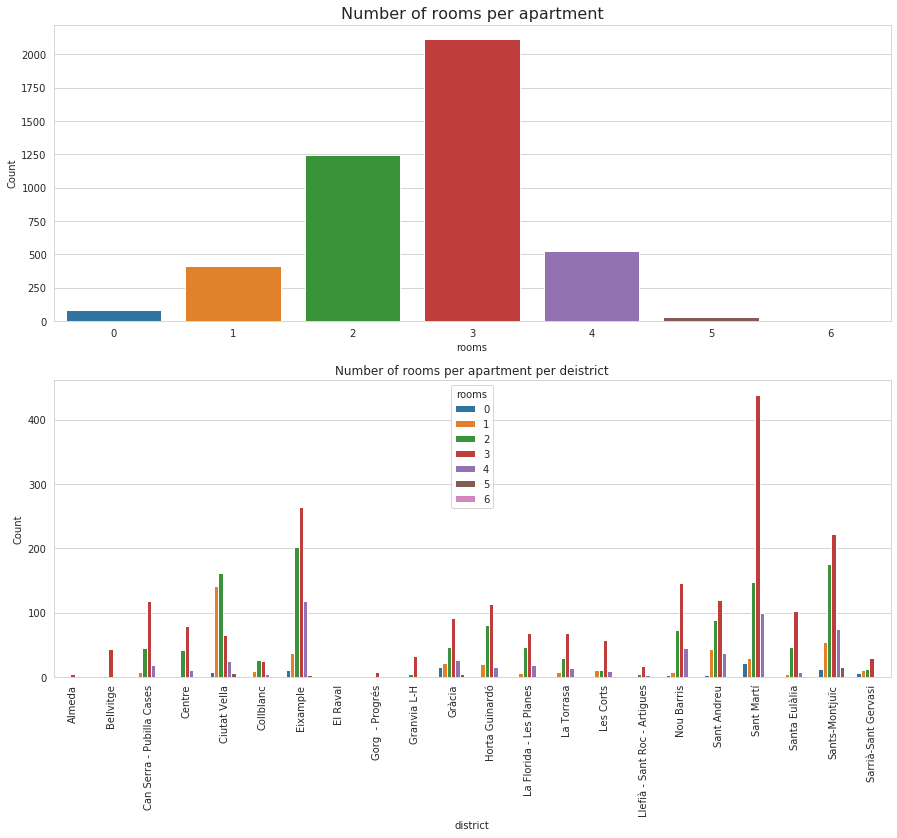

In [15]:
sns.set_style("whitegrid")
fig_size = (15,12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='rooms', orient = 0, data = df, ax = ax[0])
ax[0].set_title('Number of rooms per apartment', fontsize=16);
ax[0].set_ylabel('Count');

sns.countplot(x = 'district', hue = 'rooms', orient = 0, data = df, ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);
ax[1].set_title('Number of rooms per apartment per deistrict');
ax[1].set_ylabel('Count');


## Analyze the relationship of floor and price

### Clean floors
Clean floors and create new numerical column 'floorSort' with floor values

In [16]:
df['floor'] = df['floor'].astype('string')
df['floorSort'] = df['floor']
df['floorSort'].replace('en', str(0), inplace= True) # entreplanta = 0
df['floorSort'].replace('bj', str(-1), inplace= True) # bajo = -1
df['floorSort'].replace('ss', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('st', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('nan', str(-2), inplace= True) # nan = -2
df['floorSort'].replace('Unknown', str(-1), inplace= True) # Set unknown to -2

df.floorSort = df.floorSort.apply(pd.to_numeric)

# 'st' and 'ss' are bothsemisotano
df['floor'].replace('st', 'ss', inplace= True) 

# Show property type 'Penthouse' as floor
df.loc[df['propertyType'] == 'penthouse', 'floor'] =  'Penthouse'# Set unknown to -2
df.loc[df['propertyType'] == 'penthouse', 'floorSort'] =  df.floorSort.max() + 1# Set unknown to -2

# Create new categorical variable with floors
df['floorCategorical'] = df['floor']
df.loc[df['floorSort']==-2, ['floorCategorical']] = None
df.loc[(df['floorSort']>=1)&(df['floorSort']<=3), ['floorCategorical']] = 'Low'
df.loc[(df['floorSort']>=4)&(df['floorSort']<=6), ['floorCategorical']] = 'Mid'
df.loc[(df['floorSort']>=7)&(df['floor']!='Penthouse'), ['floorCategorical']] = 'High'
df['floorCategorical'] = df['floorCategorical'].astype('category')


### Counts and price distribution per floor

Text(0, 0.5, 'Price by Area')

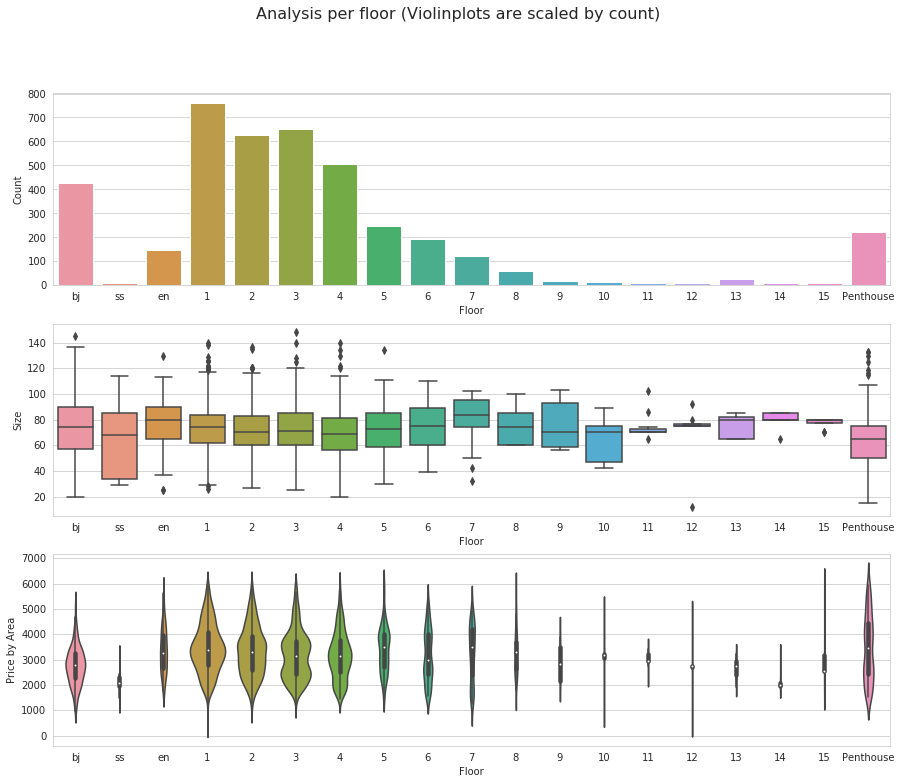

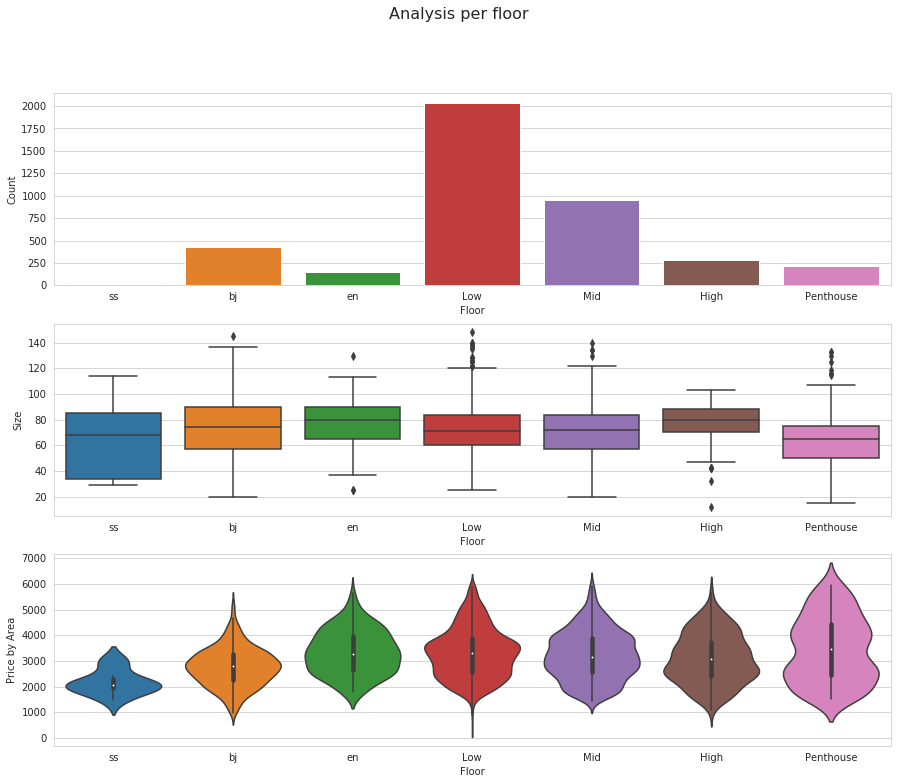

In [17]:
# Do not plot NaNs
fig_size = (15, 12)
fig, ax = plt.subplots(3, figsize=fig_size)
fig.suptitle(
    'Analysis per floor (Violinplots are scaled by count)', fontsize=16)
sns.countplot(x='floor', data=df.loc[df['floorSort'] != -
                                     2].sort_values(by=['floorSort']), orient='v', ax=ax[0])
ax[0].set_xlabel('Floor')
ax[0].set_ylabel('Count')

sns.boxplot(x='floor', y='size',
            data=df.loc[df['floorSort'] != -2].sort_values(by=['floorSort']), ax=ax[1])
ax[1].set_xlabel('Floor')
ax[1].set_ylabel('Size')

sns.violinplot(x='floor', y='priceByArea', scale='count',
               data=df.loc[df['floorSort'] != -2].sort_values(by=['floorSort']), ax=ax[2])
ax[2].set_xlabel('Floor')
ax[2].set_ylabel('Price by Area')


# Plot 'floorCategorical'
fig_size = (15, 12)
fig, ax = plt.subplots(3, figsize=fig_size)
fig.suptitle(
    'Analysis per floor', fontsize=16)
sns.countplot(x='floorCategorical', data=df, order=[
              'ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], orient='v', ax=ax[0])
ax[0].set_xlabel('Floor')
ax[0].set_ylabel('Count')

sns.boxplot(x='floorCategorical', y='size', data=df, order=[
              'ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], ax=ax[1])
ax[1].set_xlabel('Floor')
ax[1].set_ylabel('Size')

sns.violinplot(x='floorCategorical', y='priceByArea', scale='width', data=df,
               order=['ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], ax=ax[2])
ax[2].set_xlabel('Floor')
ax[2].set_ylabel('Price by Area')

### Analyze number of penthouses per district

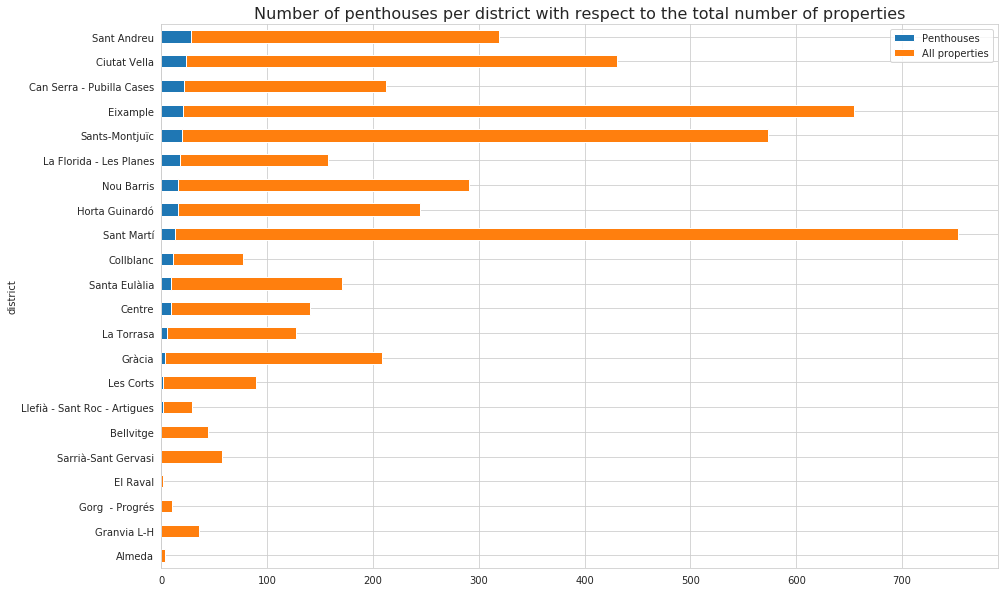

In [18]:
def get_penthouse(x):
    return x.loc[x == 'penthouse'].count()


def get_all_properties(x):
    return x.count()


fig, ax = plt.subplots(1, figsize=(15, 10))


aux = df[['district', 'propertyType']].groupby(['district']).agg(
    [get_penthouse, get_all_properties])
aux.columns = ['Penthouses', 'All properties']
aux.sort_values(by='Penthouses').plot.barh(stacked=True, ax=ax)
ax.set_title(
    'Number of penthouses per district with respect to the total number of properties', 
    fontsize=16);

## Location

### Plot properties to the map
Plot properties and penthouses with respect to price by area and size.

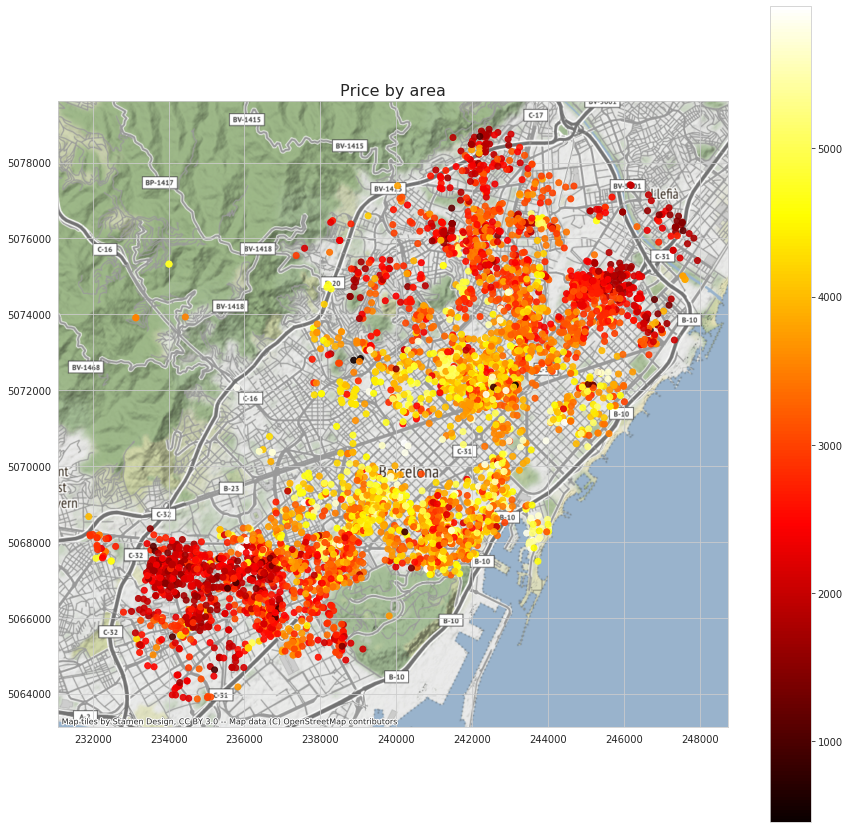

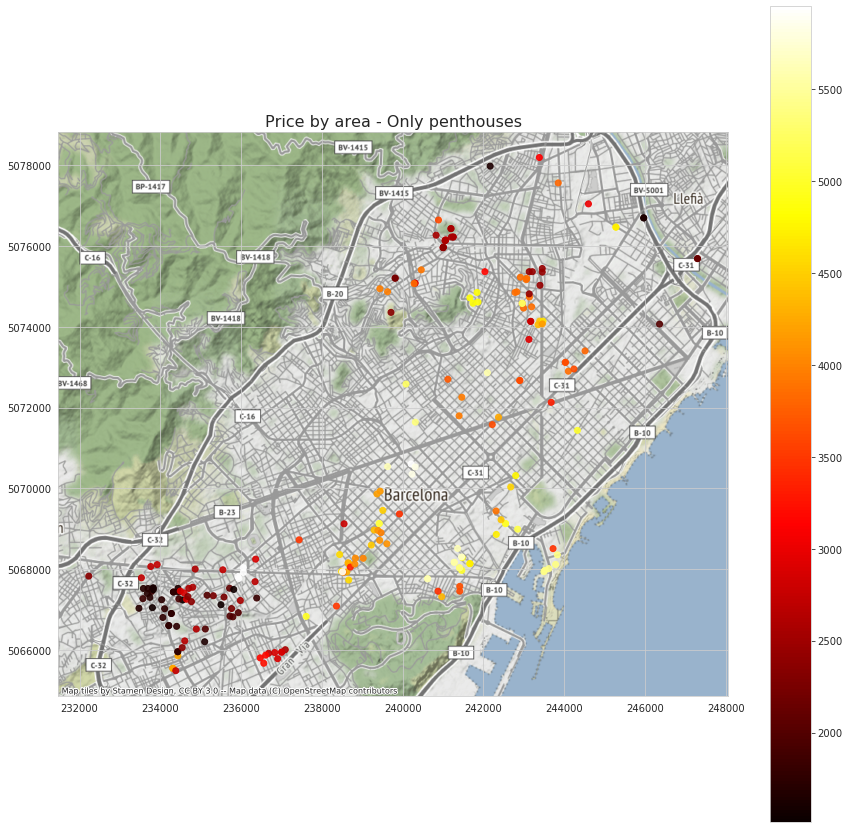

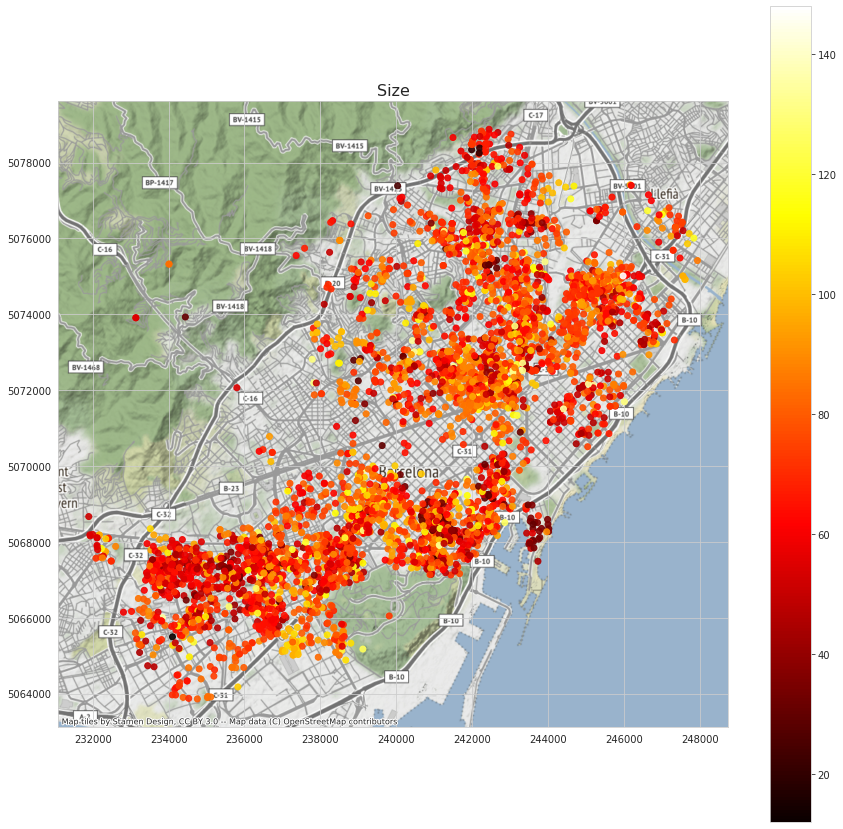

In [19]:
import geopandas as gpd
import descartes
import contextily as ctx


gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15,15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='priceByArea', cmap='hot',  legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.loc[gdf['propertyType'] == 'penthouse'].plot(
    column='priceByArea', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area - Only penthouses", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='size', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Size", fontsize=16);

### Analyze prices per district

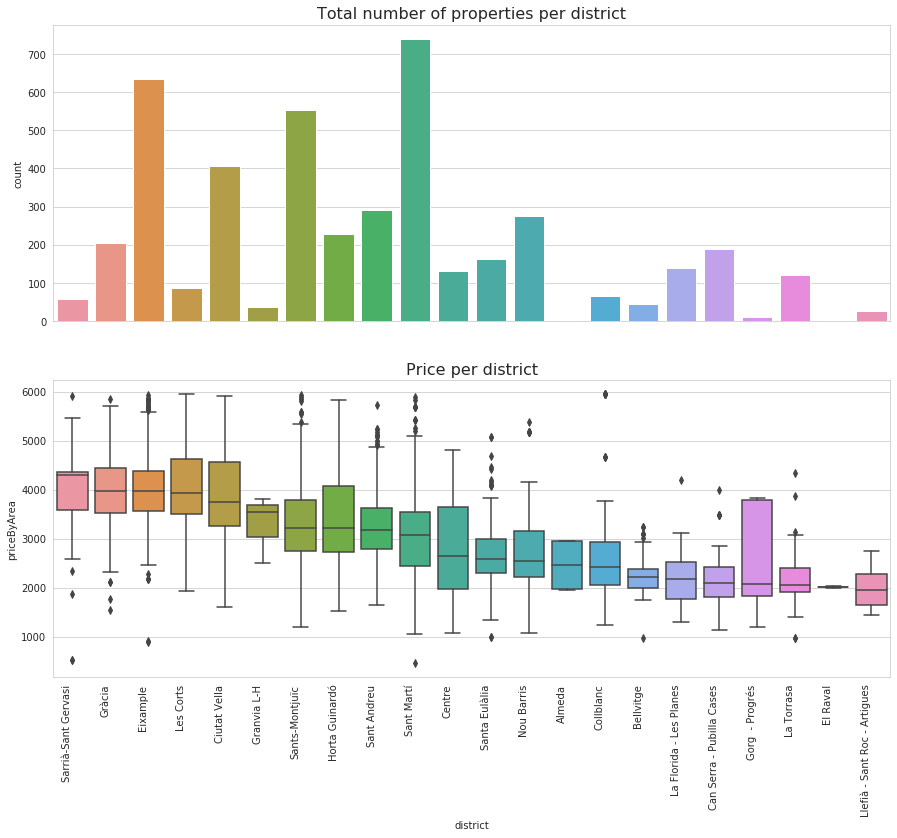

In [20]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='district', data=df,
              order=df.groupby('district')['priceByArea'].median().sort_values(ascending=False).index, orient='v', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Total number of properties per district', fontsize=16);

sns.boxplot(y='priceByArea', x='district', data=df, ax=ax[1],
            order=df.groupby('district')['priceByArea'].median().sort_values(ascending=False).index)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right')
ax[1].set_title(
    'Price per district', fontsize=16);

### Change in price over time
Check the fluctuations per week

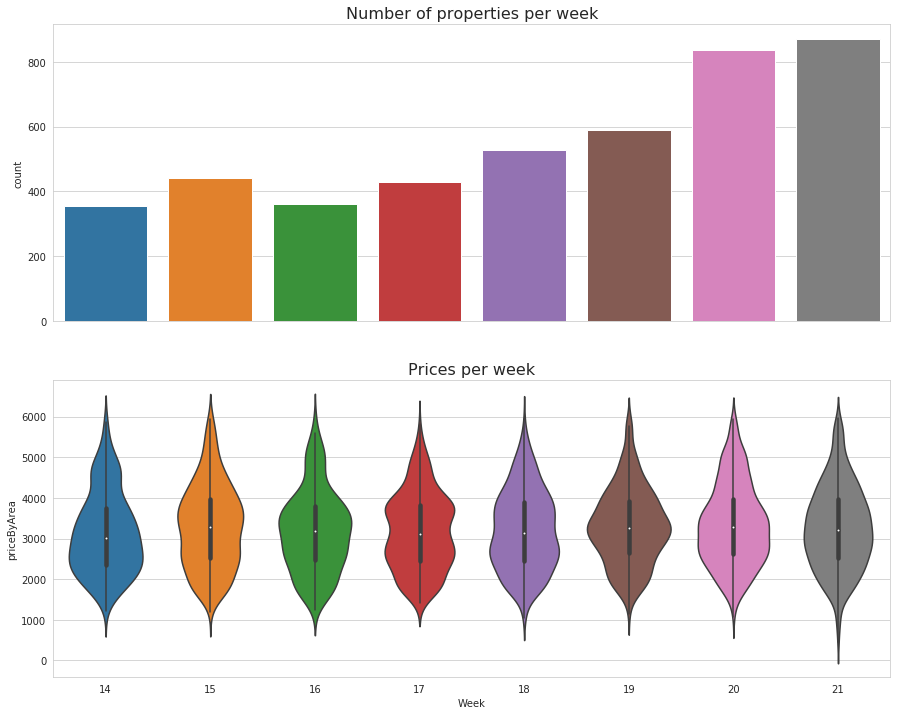

In [21]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='Week', data=df, ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Number of properties per week', fontsize=16);

sns.violinplot(x='Week', y='priceByArea', data=df, ax=ax[1])
ax[1].set_title(
    'Prices per week', fontsize=16);

# Analysis of apartment status

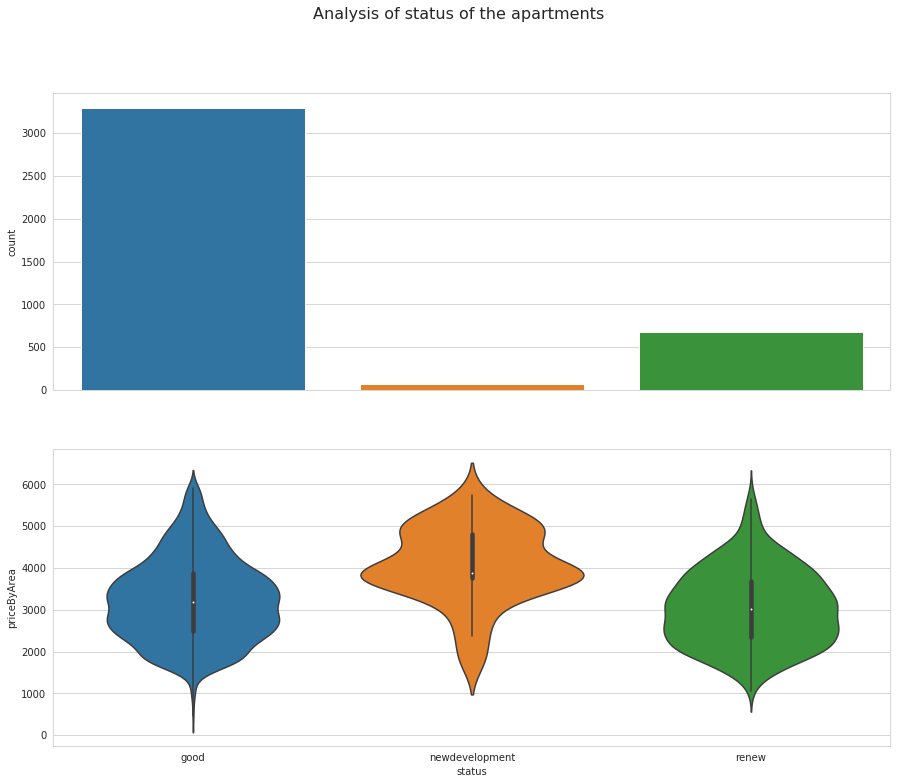

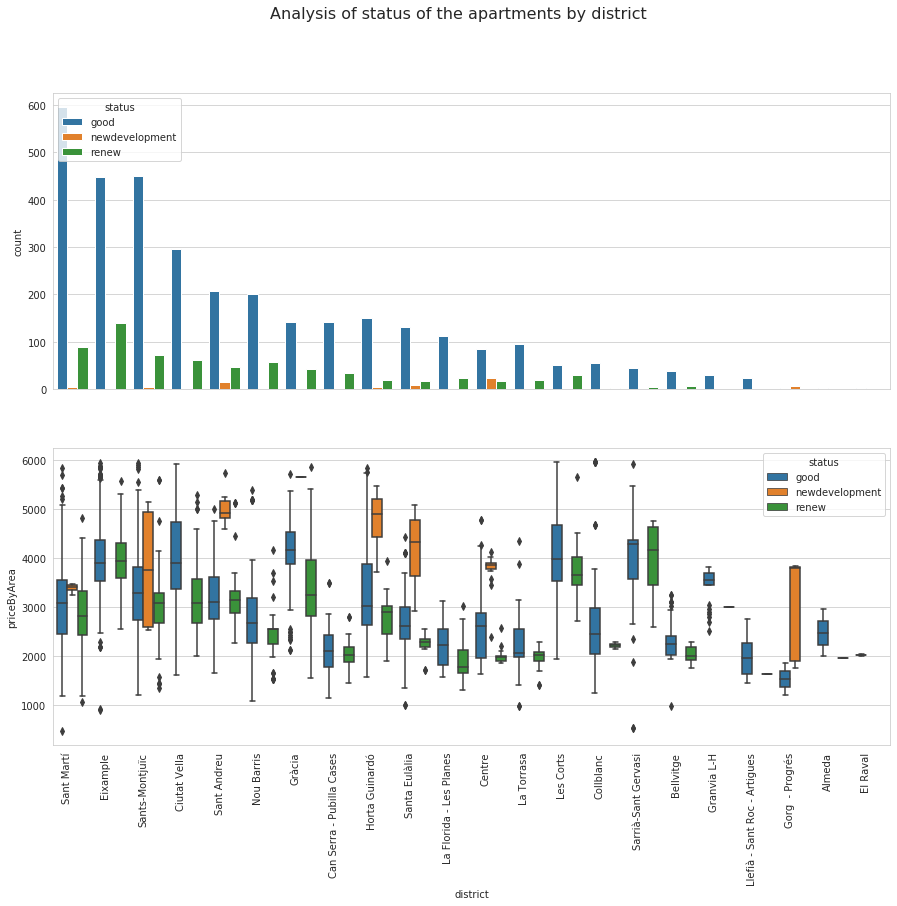

In [22]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='status', data=df, ax=ax[0]);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);
sns.violinplot(y='priceByArea', x= 'status', data=df, ax=ax[1])
fig.suptitle('Analysis of status of the apartments', fontsize=16);

fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='status', data=df, ax=ax[0],
             order=df.groupby('district')['status'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);
sns.boxplot(x='district', y='priceByArea', hue='status',data=df,ax=ax[1],
           order=df.groupby('district')['status'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of status of the apartments by district', fontsize=16);

## Analysis of elevator
Check if the elevator has an effect on the price

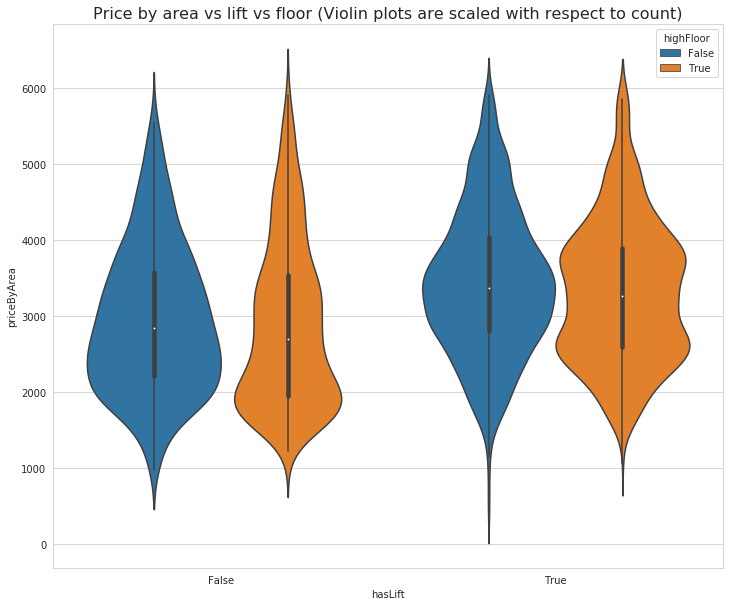

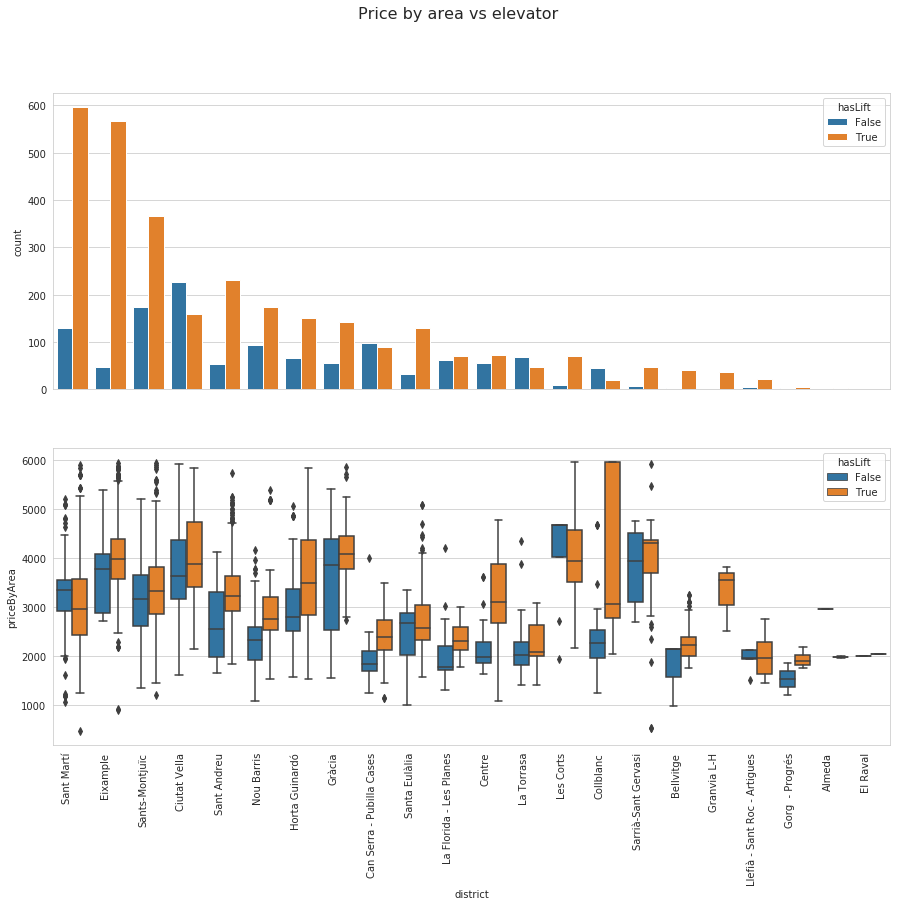

In [23]:
# Compare price by area depending on the floor and the lift
fig_size = (12, 10)
fig, ax = plt.subplots(1, figsize=fig_size)
aux=df
aux['highFloor']=False
aux.loc[aux['floorSort']>2, 'highFloor'] = True
sns.violinplot(x='hasLift', y='priceByArea', hue='highFloor', scale='count', data=aux,ax=ax);
ax.set_title('Price by area vs lift vs floor (Violin plots are scaled with respect to count)', fontsize=16);

fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='hasLift', data=df, ax=ax[0],
             order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='hasLift', data=df,ax=ax[1],
           order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Price by area vs elevator', fontsize=16);

## Exterior/interior
Check  the effect of interior/exterior property on the price

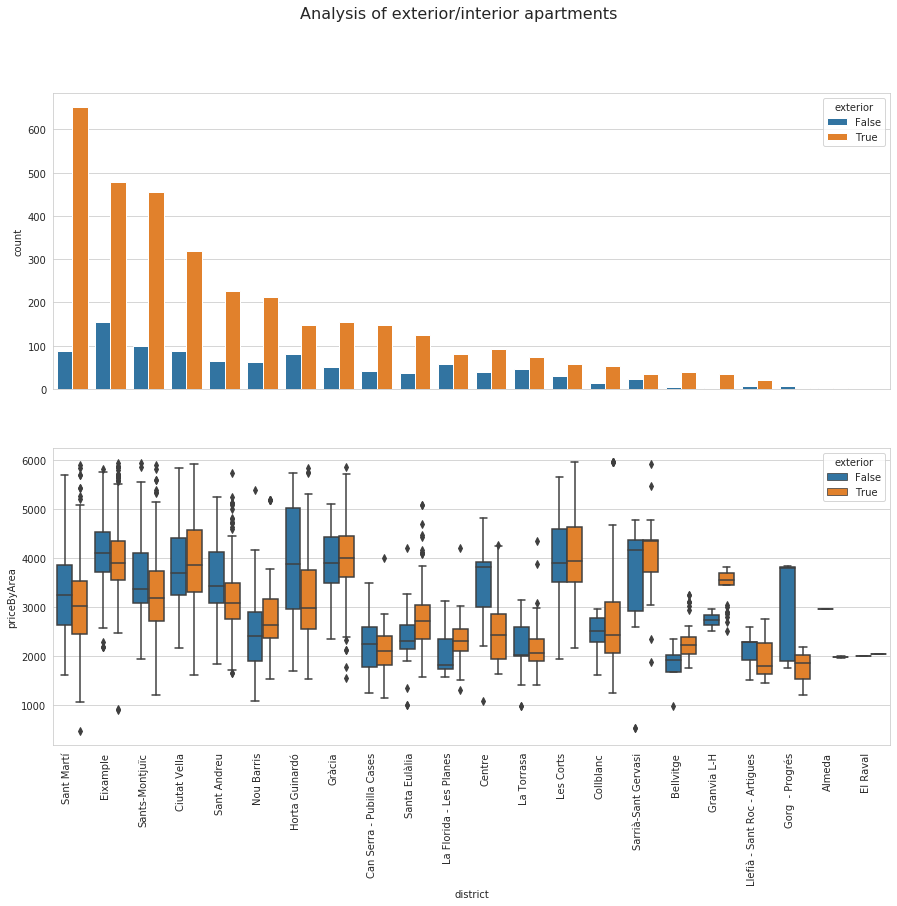

In [24]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='exterior', data=df, ax=ax[0],
             order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='exterior',data=df,ax=ax[1],
           order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of exterior/interior apartments', fontsize=16);

# Price Prediction
Using regression a price for each property is predicted. The properties with a significantly lower price than the predicted value are identified as a good investment oportunity.

### Organize and clean the data

In [25]:
# Print the names of the columns
print('Available features are:')
for i in df.columns:
    print(i, end=', ')

df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]

Available features are:
propertyCode, floor, price, propertyType, size, exterior, rooms, bathrooms, district, neighborhood, latitude, longitude, priceByArea, status, hasLift, Week, floorSort, floorCategorical, geometry, highFloor, 

In [26]:
def clean_modelling_data(df):
    data = df
    
    # drop NaNs
    numberOfNans = data.isnull().sum().sum()/data.shape[0]
    #assert numberOfNans<0.05, "Oh no! The number of NaNs is "+str(numberOfNans)+"%"
    print("The number of NaNs is "+str(numberOfNans)+"%")
    data = data.dropna().reset_index(drop=True)
    data['hasLift'] = data['hasLift'].astype('bool')

    # get 0/1 for bool varibales
    data['exterior'] = data['exterior'].astype(int)
    data['hasLift'] = data['hasLift'].astype(int)

    # get dummies for categorical variables
    data = pd.get_dummies(data)
    return data

df_model = clean_modelling_data(df_model)

The number of NaNs is 0.1961939284096058%


### Linear Regression
Simple linear regression model and the performance

The mean squared error (MSE) on train set: 663224.9088
The mean squared error (MSE) on test set: 678743.3848

The R square (R2) on train set: 0.2847
The R square (R2) on test set: 0.3011


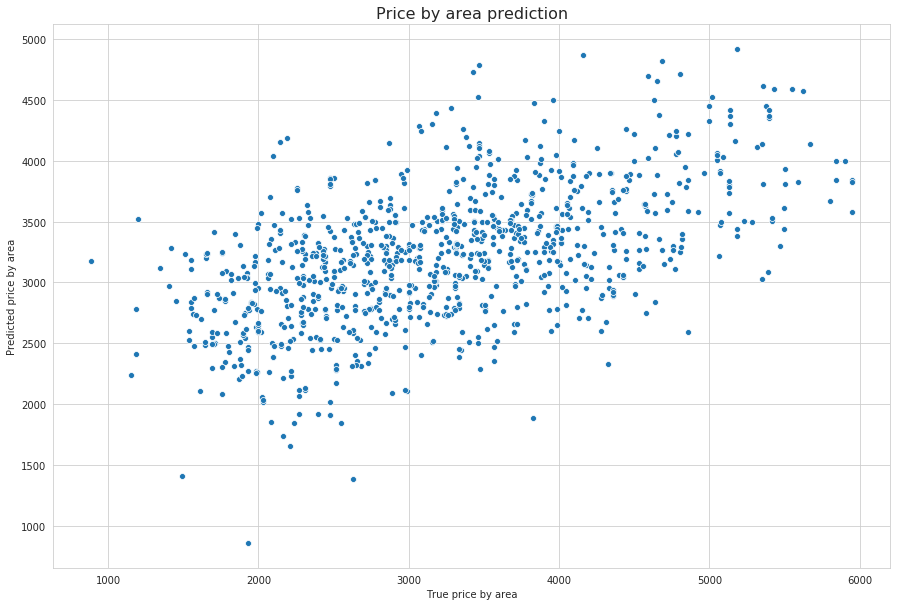

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

reg = LinearRegression()

labels = df_model['priceByArea']
train1 = df_model.drop(['priceByArea'],axis=1)
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.25,random_state =2)

reg.fit(x_train,y_train)
reg.score(x_test,y_test)

mse_train = mean_squared_error(y_train, reg.predict(x_train))
mse_test = mean_squared_error(y_test, reg.predict(x_test))
R2_train = reg.score(x_train,y_train)
R2_test = reg.score(x_test,y_test)
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))
print("\nThe R square (R2) on train set: {:.4f}".format(R2_train))
print("The R square (R2) on test set: {:.4f}".format(R2_test))
fig,ax= plt.subplots(1,figsize=(15, 10))
sns.scatterplot(x=y_test, y=reg.predict(x_test));
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction', fontsize=16);

#plt.scatter(y_test, reg.predict(x_test),  color='black');

#### Improve the linear regression using ensemble learner
Improve the linear regression using Gradient Boosting Regressor

The mean squared error (MSE) on train set: 415.7294
The mean squared error (MSE) on test set: 227697.0965

The R square (R2) on train set: 0.9996
The R square (R2) on test set: 0.7655


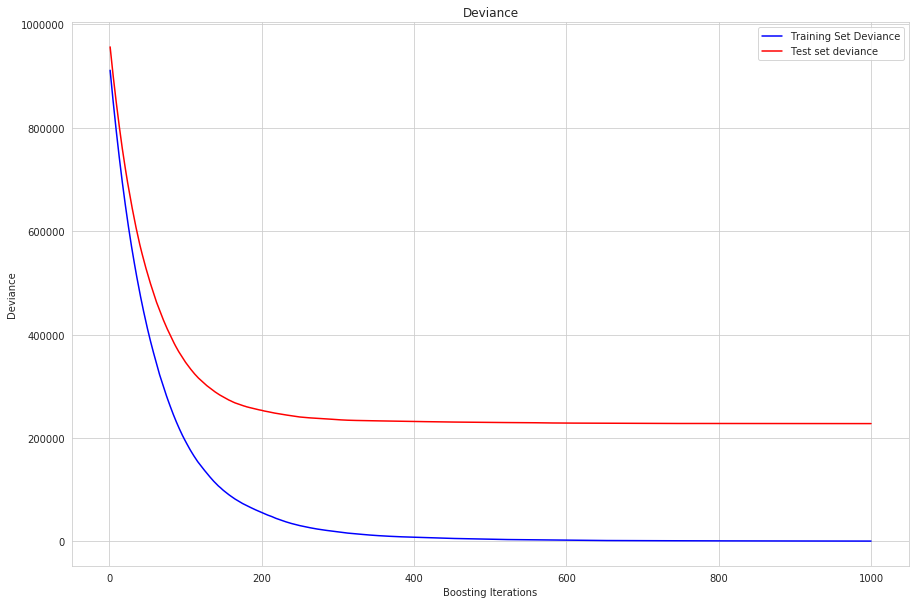

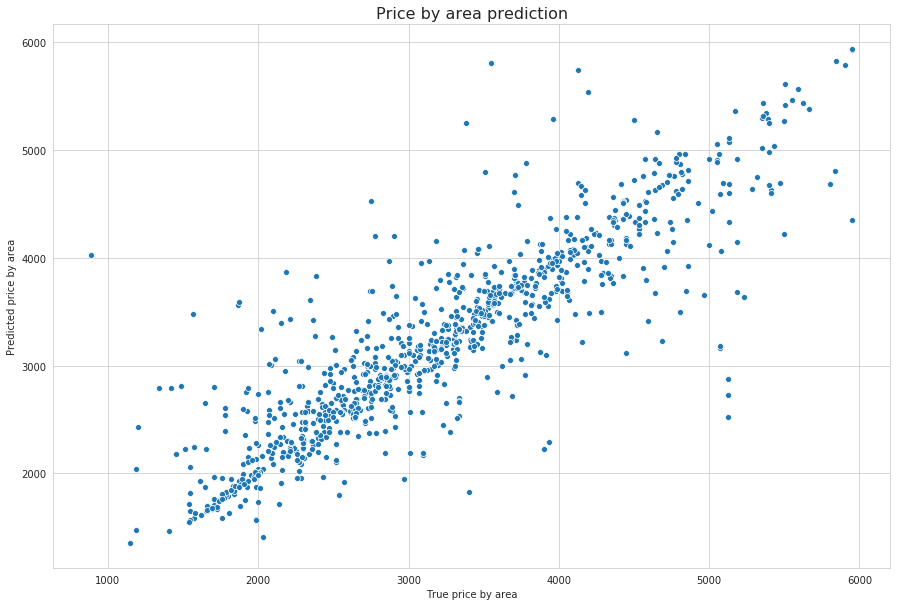

In [28]:
params = {'n_estimators': 1000,
          'max_depth': 12,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse_train = mean_squared_error(y_train, reg.predict(x_train))
mse_test = mean_squared_error(y_test, reg.predict(x_test))
R2_train = reg.score(x_train,y_train)
R2_test = reg.score(x_test,y_test)
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))
print("\nThe R square (R2) on train set: {:.4f}".format(R2_train))
print("The R square (R2) on test set: {:.4f}".format(R2_test))

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig,ax= plt.subplots(1,figsize=(15, 10))

plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
        label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test set deviance')
        
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.title('Deviance')

fig,ax= plt.subplots(1,figsize=(15, 10))
sns.scatterplot(x=y_test, y=reg.predict(x_test));
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction', fontsize=16);


The R square (R2) on test set: 0.8539


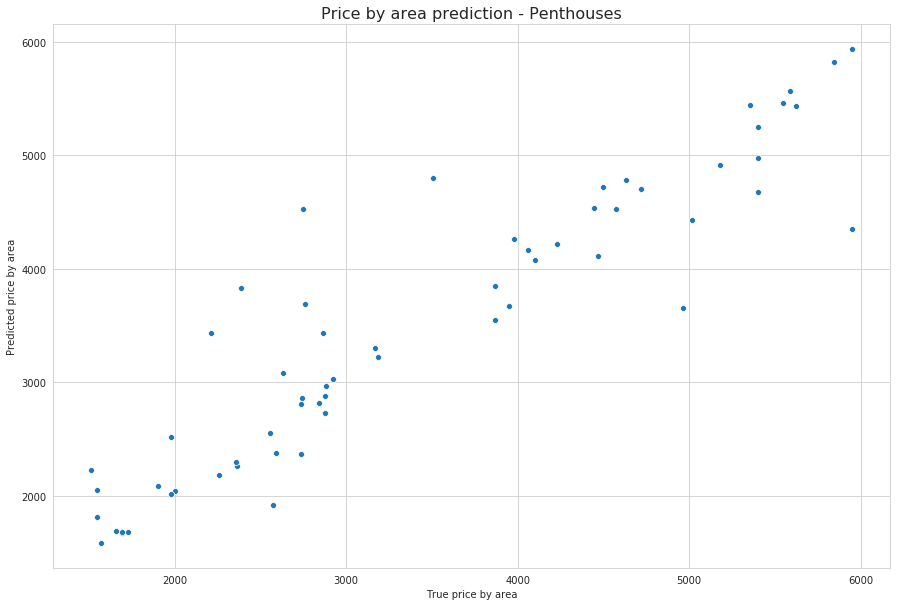

In [29]:
# Analyse error on Penthouses
R2_test_penthouse = reg.score(
    x_test.loc[x_test['propertyType_penthouse'] == 1], y_test.loc[x_test['propertyType_penthouse'] == 1])
print("The R square (R2) on test set: {:.4f}".format(R2_test_penthouse))

fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(x=y_test.loc[x_test['propertyType_penthouse'] == 1], y=reg.predict(
    x_test.loc[x_test['propertyType_penthouse'] == 1]))
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction - Penthouses', fontsize=16);

#### Perform Permutation Feature Importance analysis

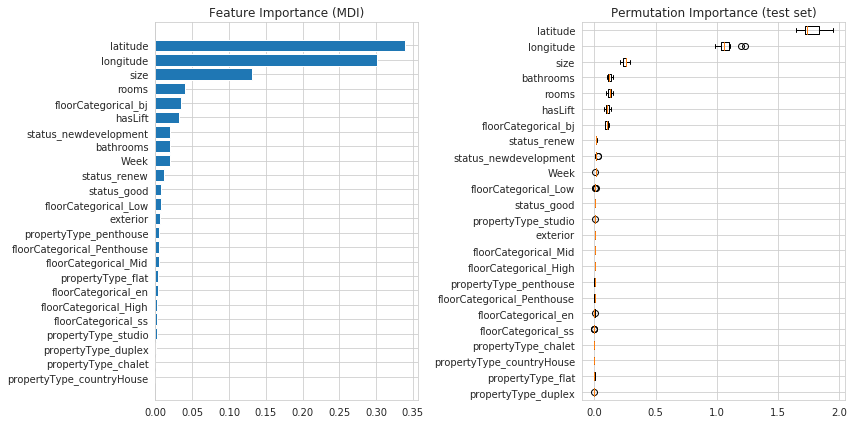

In [30]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(train1.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(train1.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()

### Identify the best offers in terms of Price by Area

#### Train the model on all samples

The number of NaNs is 0.1961939284096058%
Using features:
size, rooms, bathrooms, latitude, longitude, priceByArea, hasLift, Week, propertyType_flat, propertyType_penthouse, status_renew, floorCategorical_Low, floorCategorical_bj, The mean squared error (MSE) on train set: 8380.1497
The R square (R2) on train set: 0.9911


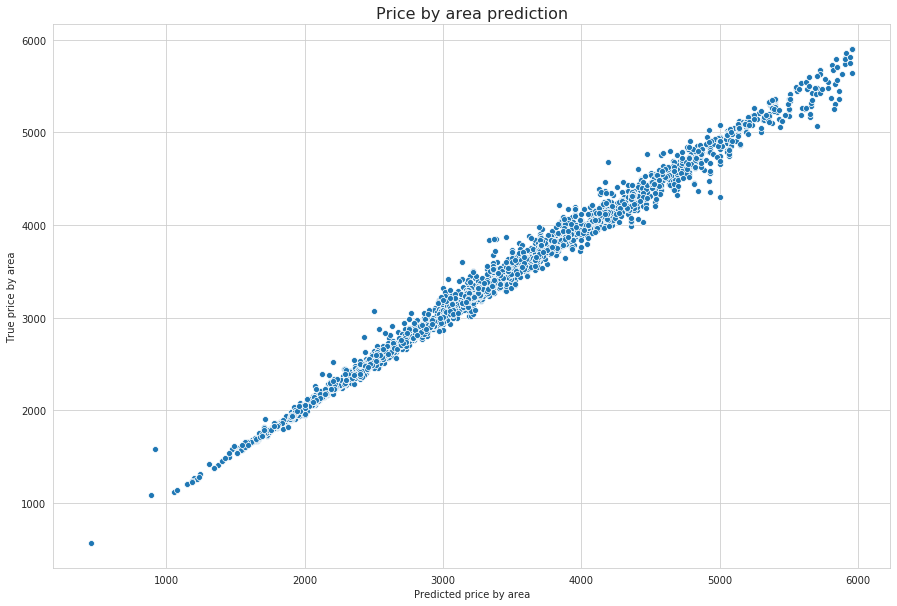

In [31]:
# Recreate feature set
df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]
df_model = clean_modelling_data(df_model)

# Drop unnecessary features
df_model = df_model.drop(['propertyType_studio', 'propertyType_duplex', 'propertyType_countryHouse', 'propertyType_chalet',
                          'status_newdevelopment', 'status_good', 'exterior',
                         'floorCategorical_High', 'floorCategorical_Mid', 'floorCategorical_en', 'floorCategorical_ss',
                          'floorCategorical_Penthouse'
                         ], axis=1)

# Print the names of the columns
print('Using features:')
for i in df_model.columns:
    print(i, end=', ')

params = {'n_estimators': 400,
          'max_depth': 12,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(df_model.drop(['priceByArea'], axis=1), df_model['priceByArea'])

mse_train = mean_squared_error(df_model['priceByArea'], reg.predict(
    df_model.drop(['priceByArea'], axis=1)))
R2_train = reg.score(df_model.drop(
    ['priceByArea'], axis=1), df_model['priceByArea'])
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The R square (R2) on train set: {:.4f}".format(R2_train))

fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(df_model['priceByArea'], reg.predict(
    df_model.drop(['priceByArea'], axis=1)))
ax.set_ylabel('True price by area');
ax.set_xlabel('Predicted price by area');
ax.set_title('Price by area prediction', fontsize=16);

#### Create new columns in df with predicted price, price difference, and savings

In [32]:
df_model['predictedPrice'] = reg.predict(df_model.drop(['priceByArea'],axis=1))
# Price difference = PredictedPrice- priceByArea ==> the higher numbers are better investment
df_model['priceDifference'] = df_model['predictedPrice']-df_model['priceByArea']

df=df.join(df_model[['predictedPrice', 'priceDifference']])
df['savings'] = df['size']*df['priceDifference']

Show only the properties cheaper more than 'threshold' than predicted price (e.g. 10 000 euros).

In [33]:
# show only the properties cheaper by threashold from predicted price 
saving_threashold = 10000
df_investment=df.loc[df['savings'] > saving_threashold]

df_investment.sort_values(by='savings',ascending=False).head(50)

propertyCode      floor     price propertyType   size  exterior  rooms  \
2459      89292990         bj  350000.0       duplex  120.0      True      2   
880       89192523          2  350000.0         flat  114.0      True      4   
3685      89431382          1  345000.0         flat   80.0      True      3   
3241      89375563         15  205000.0         flat   80.0      True      3   
3725      89423408         bj  384000.0         flat  132.0      True      4   
2758      39175444          2  330000.0         flat   92.0      True      4   
798       89197613          4  219000.0         flat   76.0      True      2   
3071      89393292          1  365000.0       duplex  109.0      True      4   
414       89152582          3  390000.0         flat   97.0      True      4   
3161      89329222          1  360000.0         flat   81.0      True      2   
3455      89361571        nan  295000.0         flat  103.0     False      4   
3569      88412678          1  363000.0         flat  108.0      True      3   
2285      89307493         bj  199000.0         flat   80.0     False      1   
2228      89277719          7  274000.0         flat   84.0      True      4   
3132      89369969         13  260000.0         flat   84.0      True      3   
2640      89267188         bj  130000.0         flat   46.0      True      1   
2619      89283608          8  340000.0         flat   98.0      True      3   
3242      89352910         bj  290000.0         flat   80.0      True      3   
2771      89354815          1  269000.0         flat   71.0     False      3   
78        89119766          1  365000.0         flat  106.0      True      3   
3109      89395284          2  260000.0         flat   75.0      True      3   
1942      89245452          4  190000.0         flat   95.0     False      4   
3770      89406423          3  138000.0         flat   60.0      True      3   
3193      89346515          3  390000.0         flat  140.0     False      4   
2192      89307010          1  340000.0         flat   78.0      True      3   
93        89125761         en  165000.0         flat   50.0      True      2   
2602      89276672        nan  330000.0         flat   83.0      True      3   
3115      89372950          3  189000.0         flat   75.0      True      3   
3058      89377165          3  145000.0         flat   70.0      True      2   
74        89115788          6  199000.0         flat   95.0      True      4   
2927      89336788          6  205000.0         flat   84.0      True      3   
2887      89360116          3  317000.0         flat   88.0      True      2   
1624      89268076          1  290000.0         flat  104.0      True      4   
1922      89258936         en  380000.0         flat   90.0     False      4   
2276      89299245          3  328000.0         flat   88.0      True      2   
3665      89459445          6  299000.0         flat   70.0      True      2   
1366      89246263  Penthouse  298000.0    penthouse   82.0      True      3   
2358      89309374          2  299000.0         flat   85.0      True      3   
3331      89357888        nan  227000.0         flat   75.0      True      4   
712       89140293          5  375000.0         flat   85.0     False      3   
1972      89232346          4  115000.0         flat   68.0      True      3   
3018      88498023          3  395000.0         flat  110.0      True      3   
3344      89361569          4  370000.0         flat  100.0     False      5   
2309      89308137          2  258000.0         flat   70.0      True      2   
1874      89263905         13  155000.0         flat   65.0      True      3   
1872      89232828          4  120000.0         flat   73.0      True      3   
1776      89232286          1  290000.0         flat  104.0      True      4   
3167      89359016         bj  145000.0       duplex  102.0      True      1   
3381      88762700          7  350000.0         flat   80.0     False      4   
3121  

#### Plot the identified properties on the map

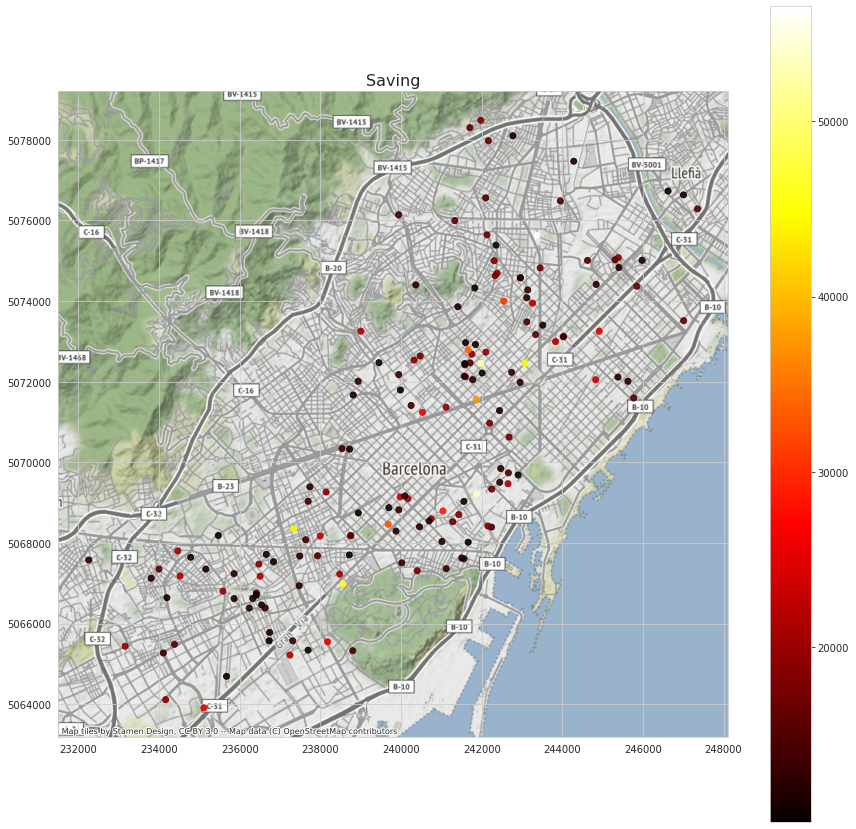

In [34]:
gdf = gpd.GeoDataFrame(
    df_investment, geometry=gpd.points_from_xy(df_investment.longitude, df_investment.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15, 15)
fig, ax = plt.subplots(1, figsize=figsize)
propertyTypeDict = {'flat': 'o', 'penthouse': 'd',
                    'studio': 's', 'duplex': '^', 'chalet': '<'}

gdf.plot(column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Saving", fontsize=16);

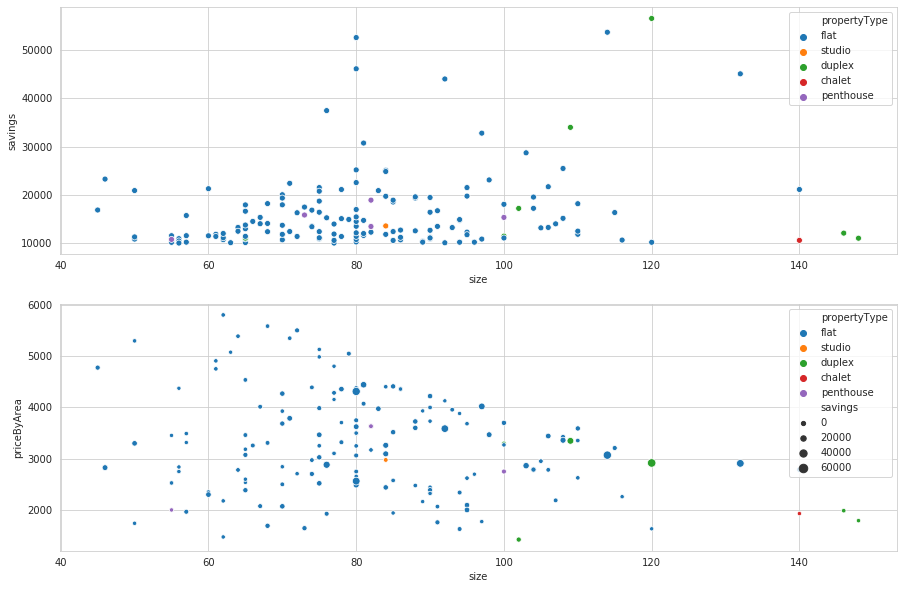

In [35]:
fig,ax= plt.subplots(2,figsize=(15, 10))
sns.scatterplot(x='size', y='savings', hue= 'propertyType', data=df_investment,ax=ax[0]);
#sns.scatterplot(x='size', y='priceByArea', hue= 'savings', data=df,ax=ax[1]);
sns.scatterplot(x='size', y='priceByArea', size= 'savings', hue='propertyType', data=df_investment,ax=ax[1]);

#### Get the identifier of the selected property

In [36]:
# E.g.:
df_investment.loc[(df_investment['size'] > 70) & (df_investment['size'] < 100) & (
    df_investment['propertyType'] == 'penthouse')].sort_values(by='savings', ascending=False)

propertyCode      floor     price propertyType  size  exterior  rooms  \
1366      89246263  Penthouse  298000.0    penthouse  82.0      True      3   
1794      89266514  Penthouse  120000.0    penthouse  73.0     False      3   
1958      89246263  Penthouse  298000.0    penthouse  82.0      True      3   

      bathrooms    district              neighborhood   latitude  longitude  \
1366          1  Sant Martí                   El Clot  41.410761   2.192147   
1794          1  Nou Barris  Les Roquetes - Canyelles  41.443490   2.175425   
1958          1  Sant Martí                   El Clot  41.410761   2.192147   

      priceByArea status hasLift  Week  floorSort floorCategorical  \
1366       3634.0   good    True    17         16        Penthouse   
1794       1644.0    NaN   False    18         16        Penthouse   
1958       3634.0   good    True    18         16        Penthouse   

                      geometry  highFloor  predictedPrice  priceDifference  \
1366  POINT (2.19215 41.41076)       True     2980.634983       230.634983   
1794  POINT (2.17542 41.44349)       True     3188.878411       216.878411   
1958  POINT (2.19215 41.41076)       True     4115.059704       164.059704   

           savings  
1366  18912.068588  
1794  15832.124034  
1958  13452.895688